In [358]:
from typing import Union, Tuple, Any, List
from abc import ABC, abstractmethod

import numpy as np
import matplotlib.pylab as plt

from dataclasses import dataclass
from shapely.geometry import Point, LineString, Polygon, box, asMultiPoint
from descartes import PolygonPatch 


In [492]:
@dataclass
class Geometry(ABC):
        
    center: Tuple[float, float, float]
    
    @abstractmethod
    def geometry(self, x=None, y=None, z=None) -> list:
        """ returns shapely geoemtry at plane specified by one non None value of x,y,z """

    def inside(self, x, y, z) -> bool:
        """ is point (x,y,z) inside volume of Geometry? (note: here is slow (point by point) way, implement vectorized on subclasses. """
        geo = self.geometry(z=z)
        loc = Point(x,y)
        return any([shape.contains(loc) for shape in geo])

    @staticmethod
    def pop_axis(coord: Tuple[Any, Any, Any], axis: int) -> Tuple[Any, Tuple[Any, Any]]:
        """separate coordinate at `axis` index from coordinates on the plane tangent to `axis`"""
        plane_vals = list(coord)
        axis_val = plane_vals.pop(axis)
        return axis_val, plane_vals

    def plot(self, x=None, y=None, z=None, ax=None, **patch_kwargs):
        """ plot structure """
        if ax is None:
            _, ax = plt.subplots()
        geo = self.geometry(x=x, y=y, z=z)
        for shape in geo:
            patch = PolygonPatch(shape, **patch_kwargs)
            ax.add_artist(patch)
        return ax

    @staticmethod
    def _parse_xyz_kwargs(**xyz) -> Tuple[int, float]:
        """ turns kwargs for plane specification like {x=None, y=None, z=None} into axis (0,1,2) and position along axis """
        xyz_filtered = {k : v for k, v in xyz.items() if v is not None}
        assert len(xyz_filtered) == 1, f"exatly one kwarg in [x,y,z] must be specified, given {xyz_filtered}."
        axis_label, position = list(xyz_filtered.items())[0]
        axis = 'xyz'.index(axis_label)
        return axis, position
    
@dataclass
class Planar(Geometry, ABC):

    axis: int
    height: float
    
    def _order_by_axis(self, plane_val: Any, axis_val: Any, axis: int) -> Tuple[Any, Any]:
        """ orders a value in the plane and value along axis in correct (x,y) order for plotting """
        vals = 3 * [plane_val]
        vals[self.axis] = axis_val
        _, (val_x, val_y) = self.pop_axis(vals, axis=axis)
        return val_x, val_y

    def geometry(self, x=None, y=None, z=None):
        """ returns shapely geometry at plane specified by one non None value of x,y,z """
        axis, position = self._parse_xyz_kwargs(x=x, y=y, z=z)
        if axis == self.axis:
            z0, _ = self.pop_axis(self.center, axis=self.axis)
            if (position < z0 - self.height/2) or (position > z0 + self.height/2):
                return []
            return self._geometry_normal()
        return self._geometry_side(position, axis)

    @abstractmethod
    def _geometry_normal(self) -> list:
        """ shapely geometry with axis normal to slab """
    
    @abstractmethod
    def _geometry_side(self, position, axis) -> list:
        """ shapely geometry with axis orthogonal to slab """

@dataclass
class Circular(Geometry):
    
    radius: float
    
    def _intersect_dist(self, position, z0):
        """ distance between points on circle at z=position where center of circle at z=z0 """
        dz = np.abs(z0 - position)
        if dz > self.radius:
            return
        return 2 * np.sqrt(self.radius**2 - dz**2)

@dataclass
class Sphere(Circular):
    """ Sphere(center=(0,0,0), radius=1.0) """

    radius: float

    def geometry(self, x=None, y=None, z=None):
        """ returns shapely geoemtry at plane specified by one non None value of x,y,z """
        axis, position = self._parse_xyz_kwargs(x=x, y=y, z=z)
        z0, (x0, y0) = self.pop_axis(self.center, axis=axis)
        intersect_dist = self._intersect_dist(position, z0)
        if not intersect_dist:
            return []
        return [Point(x0, y0).buffer(0.5 * intersect_dist)]

    def inside(self, x, y, z) -> bool:
        """returns True if (x,y,z) is inside of geometry"""
        x0, y0, z0 = self.center
        dist_x = np.abs(x - x0)
        dist_y = np.abs(y - y0)
        dist_z = np.abs(z - z0)
        return (dist_x ** 2 + dist_y ** 2 + dist_z ** 2) <= (self.radius ** 2)

@dataclass
class Cylinder(Circular, Planar):
    """ Cylinder(center=(0,0,0), radius=1.0, axis=2, length=1) """
        
    def _geometry_normal(self):
        """ shapely geometry with axis normal to slab """
        _, (x0, y0) = self.pop_axis(self.center, axis=self.axis)
        return [Point(x0, y0).buffer(self.radius)]

    def _geometry_side(self, position, axis):
        """ shapely geometry with axis orthogonal to slab """
        z0, (x0, y0) = self.pop_axis(self.center, axis=self.axis)
        intersect_dist = self._intersect_dist(position, z0)
        if not intersect_dist:
            return []
        Lx, Ly = self._order_by_axis(plane_val=intersect_dist, axis_val=self.height, axis=axis)
        return [box(minx=x0-Lx/2, miny=y0-Ly/2, maxx=x0+Lx/2, maxy=y0+Ly/2)]

    def inside(self, x, y, z) -> bool:
        """returns True if (x,y,z) is inside of geometry"""
        z0, (x0, y0) = self.pop_axis(self.center, axis=self.axis)
        dist_x = np.abs(x - x0)
        dist_y = np.abs(y - y0)
        dist_z = np.abs(z - z0)
        inside_radius = (dist_x ** 2 + dist_y ** 2) <= (self.radius ** 2)
        inside_height = dist_z < (self.height / 2)
        return inside_radius * inside_height

@dataclass
class PolySlab(Planar):
    """ PolySlab(center=(0,0,0), vertices=[(0,0), (1,0), (1,1)], length=1.0, axis=2) """
    
    vertices: List[Tuple[float, float]]
    
    def inside(self, x, y, z) -> bool:
        """returns True if (x,y,z) is inside of geometry"""
        z0, (x0, y0) = self.pop_axis(self.center, axis=self.axis)
        dist_z = np.abs(z - z0)
        inside_height = dist_z < (self.height / 2)
        face_polygon = Polygon(self.vertices)
        if isinstance(x, np.ndarray):
            inside_polygon = np.zeros_like(inside_height)
            xs_slab = x[inside_height]
            ys_slab = y[inside_height]
            def contains_pointwise(xy_point):
                point = Point(xy_point)
                return face_polygon.contains(point)
            contains_vectorized = np.vectorize(contains_pointwise, signature='(n)->()')
            points_stacked = np.stack((xs_slab, ys_slab), axis=1)
            inside_polygon_slab = contains_vectorized(points_stacked)
            inside_polygon[inside_height] = inside_polygon_slab
        else:
            point = Point(x,y)
            inside_polygon = face_polygon.contains(point)
        return inside_height * inside_polygon
    
    def _geometry_normal(self):
        """ shapely geometry with axis normal to slab """
        return [Polygon(self.vertices)]

    def _geometry_side(self, position, axis) -> list:
        """ shapely geometry with axis orthogonal to slab """

        z0, _ = self.pop_axis(self.center, axis=self.axis)
        z_min, z_max = z0 - self.height/2, z0 + self.height/2
        iverts_b, iverts_f = self._find_intersecting_vertices(position, axis)
        ints_y = self._find_intersecting_ys(iverts_b, iverts_f, position)

        # make polygon with intersections and z axis information
        polys = []
        for y_index in range(len(ints_y) // 2):
            y_min = ints_y[2 * y_index]
            y_max = ints_y[2 * y_index + 1]
            minx, miny = self._order_by_axis(plane_val=y_min, axis_val=z_min, axis=axis)
            maxx, maxy = self._order_by_axis(plane_val=y_max, axis_val=z_max, axis=axis)
            polys.append(box(minx=minx, miny=miny, maxx=maxx, maxy=maxy))

        return polys

    def _find_intersecting_vertices(self, position: float, axis: int) -> Tuple[np.ndarray, np.ndarray]:
        """find pairs of forward and backwards vertices where interescets"""

        vertices_b = np.array(self.vertices)

        # if the first coordinate refers to bounds, need to flip the vertices x,y
        if (axis == 2) or ((self.axis == 2) and (axis == 1)):
            vertices_b = np.roll(vertices_b, shift=1, axis=1)

        # get the forward vertices
        vertices_f = np.roll(vertices_b, shift=1, axis=0)

        # find which segments intersect
        intersects_b = np.logical_and((vertices_f[:, 0] <= position), (vertices_b[:, 0] > position))
        intersects_f = np.logical_and((vertices_b[:, 0] <= position), (vertices_f[:, 0] > position))
        intersects_segment = np.logical_or(intersects_b, intersects_f)
        iverts_b = vertices_b[intersects_segment]
        iverts_f = vertices_f[intersects_segment]

        return iverts_b, iverts_f

    @staticmethod
    def _find_intersecting_ys(iverts_b: np.ndarray, iverts_f: np.ndarray, position: float) -> List[float]:
        """for each intersecting segment, find intersection point (in y) assuming straight line"""

        ints_y = []
        for (vertices_f, vertices_b) in zip(iverts_b, iverts_f):
            x1, y1 = vertices_f
            x2, y2 = vertices_b
            slope = (y2 - y1) / (x2 - x1)
            y = y1 + slope * (position - x1)
            ints_y.append(y)
        ints_y.sort()
        return ints_y

@dataclass
class Box(Geometry):
    """ Box(center=(0,0,0), size=(1,1,1)) """

    size: Tuple[float, float, float]
    
    def geometry(self, x=None, y=None, z=None):
        """ returns shapely geoemtry at plane specified by one non None value of x,y,z """
        axis, position = self._parse_xyz_kwargs(x=x, y=y, z=z)
        z0, (x0, y0) = self.pop_axis(self.center, axis=axis)
        Lz, (Lx, Ly) = self.pop_axis(self.size, axis=axis)
        dz = np.abs(z0 - position)
        if dz > Lz/2:
            return []
        return [box(minx=x0-Lx/2, miny=y0-Ly/2, maxx=x0+Lx/2, maxy=y0+Ly/2)]    
    
    def inside(self, x, y, z) -> bool:
        """returns True if (x,y,z) is inside of geometry"""
        x0, y0, z0 = self.center
        Lx, Ly, Lz = self.size
        dist_x = np.abs(x - x0)
        dist_y = np.abs(y - y0)
        dist_z = np.abs(z - z0)
        return (dist_x < Lx / 2) * (dist_y < Ly / 2) * (dist_z < Lz / 2)

@dataclass
class Structure:
    geometry: Geometry
    medium: str

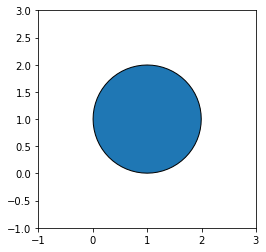

In [493]:
# sphere
s = Sphere(center=(1,1,0), radius=1)
ax = s.plot(z=0.1)
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
ax.set_aspect('equal')

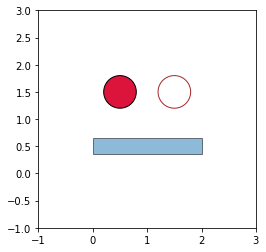

In [494]:
# box
s1 = Sphere(center=(0.5,1.5,0), radius=.3)
s2 = Sphere(center=(1.5,1.5,0), radius=.3)
b = Box(center=(1,0.5,0), size=(2,.3,0))

ax = s1.plot(z=0, facecolor='crimson')
ax = s2.plot(z=0, edgecolor='brown', fill=False, ax=ax)
ax = b.plot(z=0, ax=ax, alpha=0.5)

ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
ax.set_aspect('equal')
plt.show()

In [495]:
s1.geometry(z=0)[0].length

1.8841986941728517

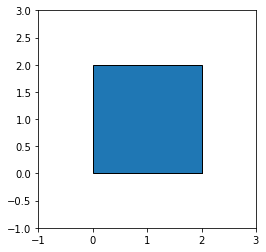

In [496]:
c = Cylinder(center=(1,1,1), radius=1, length=2, axis=1)
ax = c.plot(x=1.1)
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
ax.set_aspect('equal')
plt.show()

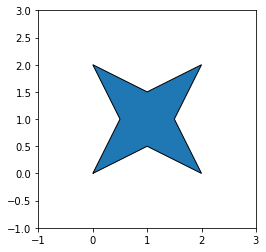

In [497]:
p = PolySlab(center=(1,1,1), vertices=[(0, 0), (1, 0.5), (2, 0), (1.5, 1), (2, 2), (1, 1.5), (0, 2), (0.5, 1)], length=2, axis=2)
ax = p.plot(z=1.8)
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
ax.set_aspect('equal')
plt.show()

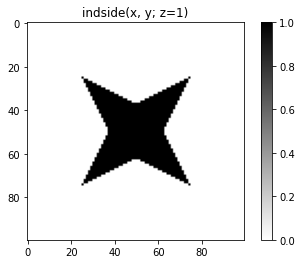

In [498]:
num = 100
pts = np.linspace(-1, 3, num)
x, y, z = np.meshgrid(pts, pts, pts, indexing='ij')
x, y, z = x.flatten(), y.flatten(), z.flatten()
inside = p.inside(x, y, z)
inside = inside.reshape((num, num, num))
im = plt.imshow(inside[..., num//2], cmap='gist_yarg')
plt.colorbar(im)
plt.title('indside(x, y; z=1)')
plt.show()